# Assignment 3 — Association Rule Mining

**Dataset:** `bread_basket.csv` (11569 transactions)

Fill in the short answer cells and run the code cells. This notebook generates the required tables and figures.

**Sections:**
1. Setup & Data Load
2. EDA (a–e)
3. Frequent Itemset Mining (FP-Growth)
4. Association Rules + Report Table
5. Rule Subgraph (Bread, Coffee, Cake, Tea)
6. Interpretation Prompt


## 1) Setup & Data Load (10 pts)
- Place `bread_basket.csv` in the same folder as this notebook **or** update the path below.
- Needed packages: `pandas`, `matplotlib`, `mlxtend`, `networkx` (for the small graph).
- If a package is missing, run the `pip install` cell.

In [37]:
# write your answer here
import pandas as pd
import matplotlib.pyplot as plt
import mlxtend as mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import warnings
warnings.filterwarnings('ignore')
import networkx as nx

# Load the dataset
data = pd.read_csv('bread_basket.csv')
data.head()

,transaction,item,date_time,time,period_day,weekday_weekend
0,1,Bread,30/10/2016,9:58,morning,weekend
1,2,Scandinavian,30/10/2016,10:05,morning,weekend
2,2,Scandinavian,30/10/2016,10:05,morning,weekend
3,3,Hot chocolate,30/10/2016,10:07,morning,weekend
4,3,Jam,30/10/2016,10:07,morning,weekend


## 2) EDA (a–e) (30 pts)
### a) List variables and their dtypes (5 pts)

In [38]:
# write your answer here
print(data.dtypes) # to check the data types of each column in the dataset, which can help identify if any columns need to be converted to the appropriate type for analysis.

transaction         int64
item               object
date_time          object
time               object
period_day         object
weekday_weekend    object
dtype: object


### b) "Statistics" overview (5 pts)
Use `describe(include='all')` as a stand‑in for RapidMiner's Statistics. Take a screenshot when you submit.

In [39]:
# write your answer here
print(data.describe(include='all')) # to get a summary of the dataset, including counts, unique values, top values, and frequency for categorical columns.


         transaction    item   date_time   time period_day weekday_weekend
count   20507.000000   20507       20507  20507      20507           20507
unique           NaN      94         159   1255          4               2
top              NaN  Coffee  2017-02-04  11:06  afternoon         weekday
freq             NaN    5471         292     52      11569           12807
mean     4976.202370     NaN         NaN    NaN        NaN             NaN
std      2796.203001     NaN         NaN    NaN        NaN             NaN
min         1.000000     NaN         NaN    NaN        NaN             NaN
25%      2552.000000     NaN         NaN    NaN        NaN             NaN
50%      5137.000000     NaN         NaN    NaN        NaN             NaN
75%      7357.000000     NaN         NaN    NaN        NaN             NaN
max      9684.000000     NaN         NaN    NaN        NaN             NaN


In [40]:
data.isnull().sum() # to check for missing values in the dataset.

transaction        0
item               0
date_time          0
time               0
period_day         0
weekday_weekend    0
dtype: int64

### c) Bar plot — count of **unique transactions per item** (10 pts)
Set the subtitle to your **FirstName LastName**. Take a screenshot of the figure.

In [41]:
print("the total number of transactions is:", data["transaction"].nunique(), end = "\n\n") # to find the total number of unique transactions in the dataset by counting the unique values in the 'transaction' column.
data['transaction'].value_counts(normalize = True).head() # to display the top 5 most frequent transactions in the dataset by counting the occurrences of each unique value in the 'transaction' column and displaying the top 5.

the total number of transactions is: 9465



transaction
6716    0.000536
6279    0.000536
6474    0.000536
6412    0.000536
6045    0.000488
Name: proportion, dtype: float64

In [42]:
print("the total number of unique items is:", data["item"].nunique(), end = "\n\n") # to find the total number of unique items in the dataset by counting the unique values in the 'item' column.
data['item'].value_counts(normalize = True).head() # to display the top 5 most frequent items in the dataset by counting the occurrences of each unique value in the 'item' column and displaying the top 5.

the total number of unique items is: 94



item
Coffee    0.266787
Bread     0.162140
Tea       0.069976
Cake      0.049983
Pastry    0.041742
Name: proportion, dtype: float64

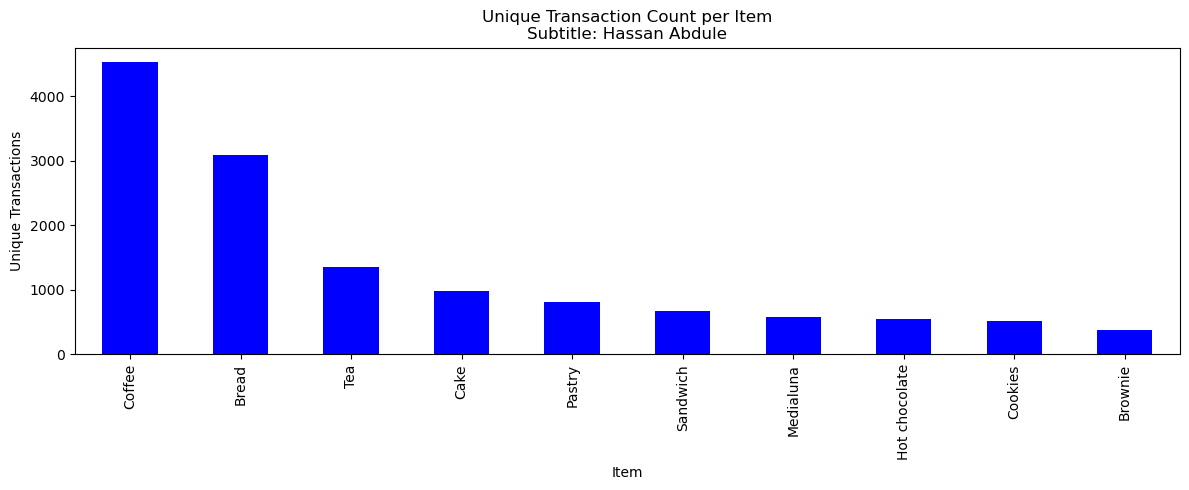

In [43]:
# c) Bar plot of transaction counts per item
# subtitle = " "  # <-- EDIT THIS
# item_counts =  # <-- EDIT THIS

item_counts = (
    data.groupby('item')['transaction']
    .nunique()
    .sort_values(ascending=False)
    .head(10)
)

ax = item_counts.plot(kind='bar', figsize=(12,5), color='blue')
subtitle = 'Hassan Abdule'
plt.title(f"Unique Transaction Count per Item\nSubtitle: {subtitle}")
plt.xlabel("Item")
plt.ylabel("Unique Transactions")
plt.tight_layout()
plt.show()

### d) Report counts for Coffee, Tea, Alfajores, Juice, and Chicken Stew (10 pts)


In [44]:
# write your answer here
items_of_interest = ['Coffee', 'Tea', 'Alfajores', 'Juice', 'Chicken Stew']
for item in items_of_interest:
    counts = data[data['item'] == item]['transaction'].nunique()
    print(f"{item}: {counts} transactions")



Coffee: 4528 transactions
Tea: 1350 transactions
Alfajores: 344 transactions
Juice: 365 transactions
Chicken Stew: 123 transactions


## 3) Frequent Itemset Mining with FP‑Growth (min_support = 0.2) (20 pts)
We pivot the data to a **transaction × item** one‑hot table (boolean), then run FP‑Growth.

In [45]:
basket = data.groupby('transaction')['item'].apply(list) # to create a basket matrix where rows represent transactions and columns represent items, with the count of each item in each transaction. 
basket.head()

transaction
1                          [Bread]
2     [Scandinavian, Scandinavian]
3    [Hot chocolate, Jam, Cookies]
4                         [Muffin]
5          [Coffee, Pastry, Bread]
Name: item, dtype: object

In [46]:
te = TransactionEncoder()
te_ary = te.fit(basket).transform(basket) # to transform the basket matrix.
basket_df = pd.DataFrame(te_ary, columns=te.columns_).astype(bool) # to create a DataFrame from the transformed basket.
basket_df.head() # to display the first few rows of the basket DataFrame, which shows the binary representation of transactions and items.

,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [47]:
basket_df.shape # to check the shape of the basket DataFrame, which indicates the number of transactions (rows) and the number of unique items (columns) in the dataset.

(9465, 94)

In [51]:

frequent_itemsets = fpgrowth(basket_df, min_support=0.02, use_colnames=True) # to find frequent itemsets in the basket dataframe using the fpgrowth alogrithm.
frequent_itemsets.head() # to display the first few rows of the frequent itemsets DataFrame, which shows the itemsets that meet the minimum support threshold.


,support,itemsets
0,0.327205,(Bread)
1,0.029054,(Scandinavian)
2,0.058320,(Hot chocolate)
3,0.054411,(Cookies)
4,0.038457,(Muffin)


In [52]:

pairs = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) == 2)].sort_values(by='support', ascending=False) # to filter the frequent itemsets to include only those that contain exactly 2 items.
print('There are', len(pairs), 'pairs of items that are frequently purchased together.') # to display the pairs of items that are frequently purchased 
print(pairs)

There are 14 pairs of items that are frequently purchased together.
     support                 itemsets
19  0.090016          (Bread, Coffee)
28  0.054728           (Coffee, Cake)
25  0.049868            (Coffee, Tea)
22  0.047544         (Coffee, Pastry)
31  0.038246       (Coffee, Sandwich)
24  0.035182      (Coffee, Medialuna)
20  0.029583  (Coffee, Hot chocolate)
23  0.029160          (Bread, Pastry)
21  0.028209        (Coffee, Cookies)
26  0.028104             (Bread, Tea)
29  0.023772              (Cake, Tea)
32  0.023666          (Toast, Coffee)
30  0.023349            (Bread, Cake)
27  0.020602          (Juice, Coffee)


## 4) Association Rules + Report Table (30 pts)
(metric = confidence, min_threshold = ?) Please find a suitable min_threshold

In [54]:
# write your answer here
raw_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1) # to generate association rules from the frequent itemsets using the association_rules with a minimum confidence threshold of 0.1.
raw_rules.head() # to display the first few rows of the generated association rules, which include the antecedents, consequents, support, confidence, and lift for each rule.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Bread),(Coffee),0.327205,0.478394,0.090016,0.275105,0.575059,1.0,-0.066517,0.719561,-0.523431,0.125794,-0.389737,0.231634
1,(Coffee),(Bread),0.478394,0.327205,0.090016,0.188163,0.575059,1.0,-0.066517,0.828731,-0.586210,0.125794,-0.206665,0.231634
2,(Hot chocolate),(Coffee),0.058320,0.478394,0.029583,0.507246,1.060311,1.0,0.001683,1.058553,0.060403,0.058333,0.055314,0.284542
3,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447,1.083723,1.0,0.002179,1.083174,0.081700,0.055905,0.076787,0.288707
4,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,1.0,0.006351,1.164682,0.146161,0.091968,0.141396,0.325764


In [55]:
rules = raw_rules[['antecedents', 'consequents','support','confidence', 'lift']].sort_values(['lift', 'confidence'], ascending=False)

rules.head(15)

,antecedents,consequents,support,confidence,lift
14,(Tea),(Cake),0.023772,0.166667,1.604781
13,(Cake),(Tea),0.023772,0.228891,1.604781
17,(Toast),(Coffee),0.023666,0.704403,1.472431
6,(Medialuna),(Coffee),0.035182,0.569231,1.189878
4,(Pastry),(Coffee),0.047544,0.552147,1.154168
10,(Juice),(Coffee),0.020602,0.534247,1.116750
16,(Sandwich),(Coffee),0.038246,0.532353,1.112792
12,(Cake),(Coffee),0.054728,0.526958,1.101515
11,(Coffee),(Cake),0.054728,0.114399,1.101515
3,(Cookies),(Coffee),0.028209,0.518447,1.083723


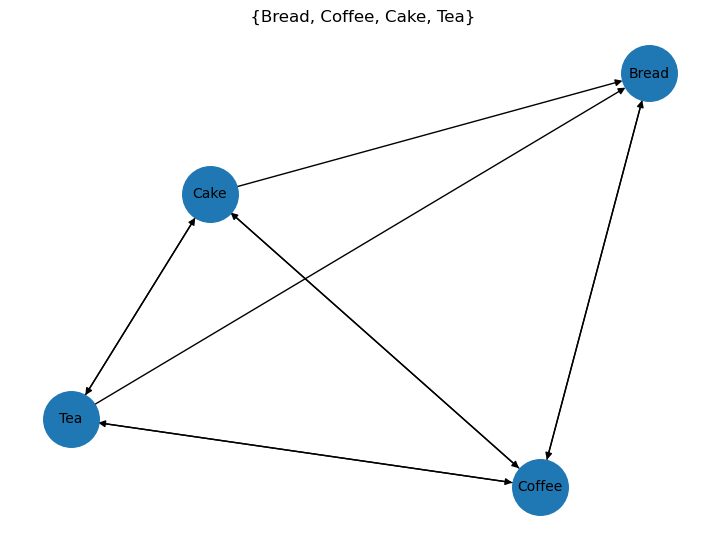

In [56]:
labels = {'Bread','Coffee','Cake','Tea'}
TA = raw_rules[
    raw_rules['antecedents'].apply(lambda s: s.issubset(labels)) &
    raw_rules['consequents'].apply(lambda s: s.issubset(labels))
].copy()

G = nx.DiGraph()
for _, r in TA.iterrows():
    a = ','.join(sorted(list(r['antecedents'])))
    c = ','.join(sorted(list(r['consequents'])))
    G.add_edge(a, c, weight=float(r['confidence']), lift=float(r['lift']))

plt.figure(figsize=(7,5))
pos = nx.spring_layout(G, seed=0)
nx.draw(G, pos, with_labels=True, node_size=1600, font_size=10, arrows=True)
plt.title(" {Bread, Coffee, Cake, Tea}")
plt.show()

## 5) Interpretation (10 pts)
**Interpret the rule `{Coffee, Cake} ⇒ {Bread}` in plain English.**

- **Support**: What fraction of *all* transactions contain Coffee, Cake, and Bread together?
- **Confidence**: Among baskets with Coffee and Cake, what share also include Bread?
- **Lift > 1** implies positive association; comment on practical meaning.

*Your notes:* (write your answer here)

> 

about 1.00% of all transactions contain Coffee, Cake, and Bread together.
about 18.34% of baskets that have Coffee and Cake also include Bread.
when the lift is > 1 it means coffee and cake buyers are more likely to get bread as well and when is less then 1 it means the opposite 
Apriori is the slow way, FP-Growth is the faster way, and both find items people buy together.

